In [1]:
%matplotlib inline

from pathlib import Path
import os

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
import numpy as np
from scipy.signal import butter

from IPython.display import display, Audio

import torch
import torchaudio
from speechbrain.dataio.dataio import read_audio_info, read_audio
import speechbrain.processing.features as spf
from speechbrain.augment.time_domain import Resample



/Users/rahulbrito/opt/miniconda3/envs/b2ai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
signal.shape

torch.Size([1, 51419])

In [18]:
signal.unsqueeze(0).shape

torch.Size([1, 1, 51419])

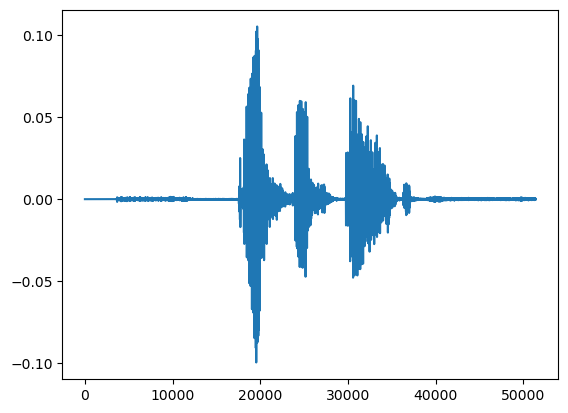

In [2]:
filename = 'test_audio.wav'
tmpdir = Path(os.path.abspath('model_dir'))
signal =read_audio(filename)
#signal = signal[:, [0]]
signal = signal.unsqueeze(0)

meta  = read_audio_info(filename)
display(Audio(data=signal.squeeze(), rate=meta.sample_rate))

b, a = butter(9, 7000/(meta.sample_rate/2))
filtered = torchaudio.functional.filtfilt(signal.squeeze(), 
                                          a_coeffs=torch.tensor(a.astype(np.float32)), 
                                          b_coeffs=torch.tensor(b.astype(np.float32)))

resampler = Resample(orig_freq=meta.sample_rate, new_freq=16000)
resampled = resampler(filtered.unsqueeze(0))
signal.shape, resampled.shape
display(Audio(data=resampled.squeeze(), rate=16000))
signal = resampled
fs = 16000
torchaudio.save('test_audio_16k_single.wav', signal.squeeze().unsqueeze(0), fs) 
plt.plot(resampled.squeeze())

torch.Size([1, 322, 601, 2])
torch.Size([322, 601])


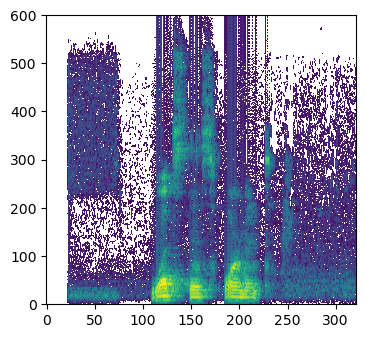

In [3]:
compute_STFT = spf.STFT(
    sample_rate=fs, win_length=25, hop_length=10, n_fft=1200
)
features = compute_STFT(signal)
print(features.shape)
features = spf.spectral_magnitude(features.squeeze())
print(features.shape)
ax = plt.matshow(features.T, origin='lower', aspect=0.5, norm=LogNorm(vmin=0, vmax=10))
ax.axes.xaxis.set_ticks_position('bottom')

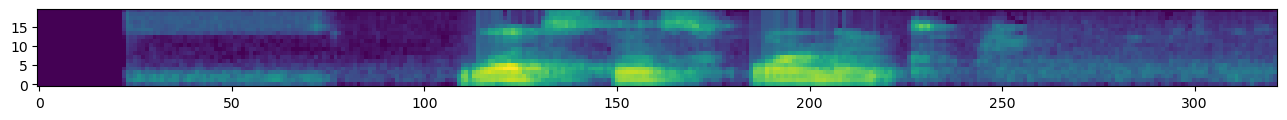

In [4]:
compute_fbanks = spf.Filterbank(n_mels=20, n_fft=1200)
features = compute_fbanks(features.unsqueeze(0))
ax = plt.matshow(features.squeeze().T, origin='lower', aspect=1)
ax.axes.xaxis.set_ticks_position('bottom')

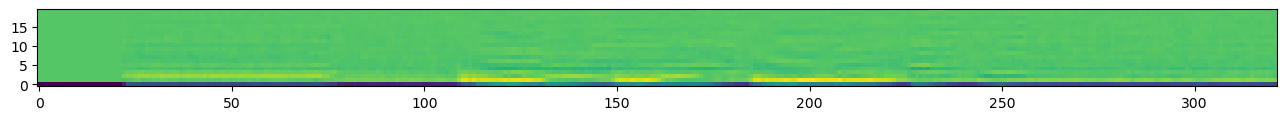

In [5]:
compute_mfccs = spf.DCT(input_size=features.shape[-1], n_out=20)
features = compute_mfccs(features)
ax = plt.matshow(features.squeeze().T, origin='lower', aspect=1)
ax.axes.xaxis.set_ticks_position('bottom')

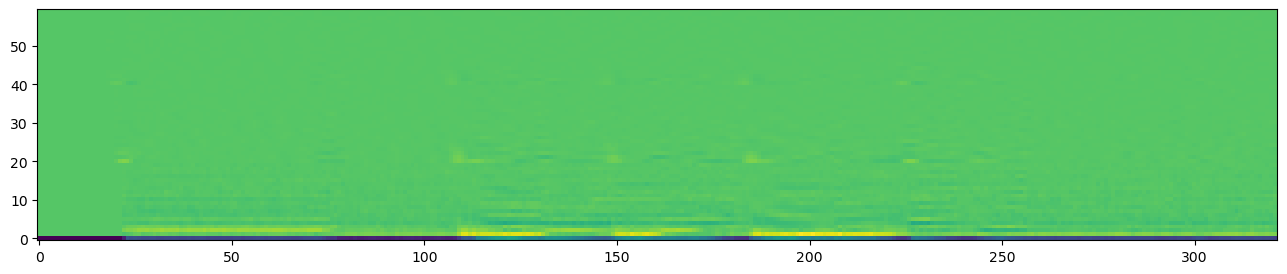

In [6]:
compute_deltas = spf.Deltas(input_size=features.shape[-1])
delta1 = compute_deltas(features)
delta2 = compute_deltas(delta1)
features = torch.cat([features, delta1, delta2], dim=2)
ax = plt.matshow(features.squeeze().T, origin='lower', aspect=1)
ax.axes.xaxis.set_ticks_position('bottom')

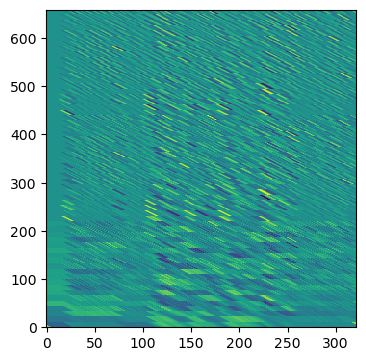

In [7]:
compute_cw = spf.ContextWindow(left_frames=5, right_frames=5)
features  = compute_cw(features)
norm = spf.InputNormalization()
features = norm(features, torch.tensor([1]).float())
ax = plt.matshow(features.squeeze().T, origin='lower', aspect=0.5)
ax.axes.xaxis.set_ticks_position('bottom')

### Speaker embeddings and verification

In [8]:
from speechbrain.inference.speaker import EncoderClassifier

device = 'cpu'
#device = 'mps

classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb", 
                                            savedir=tmpdir / 'spkrec-ecapa-voxceleb',
                                            run_opts={"device": device})

signal, fs = torchaudio.load('test_audio.wav')
embeddings = classifier.encode_batch(signal)

In [9]:
embeddings.shape

torch.Size([1, 1, 192])

In [10]:
from speechbrain.inference.speaker import SpeakerRecognition
verification = SpeakerRecognition.from_hparams(
    source="speechbrain/spkrec-ecapa-voxceleb",
    savedir=tmpdir / 'spkrec-ecapa-voxceleb',
    run_opts={"device": device}
)

signal, fs = torchaudio.load("test_audio.wav")
signal2, fs = torchaudio.load("test_audio2.wav")
score, prediction = verification.verify_batch(signal, signal2)
score, prediction

(tensor([[0.7717]]), tensor([[True]]))

In [11]:
verification.verify_files('test_audio.wav', 'test_audio_16k_single.wav')

(tensor([0.9775]), tensor([True]))

In [12]:
import torchaudio
from speechbrain.inference.encoders import MelSpectrogramEncoder

spk_emb_encoder = MelSpectrogramEncoder.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb-mel-spec",
                                                     savedir=tmpdir / 'spkrec-ecapa-voxceleb-mel-spec'
                                                    )

signal, fs = torchaudio.load("test_audio_16k_single.wav")
spk_embedding = spk_emb_encoder.encode_waveform(signal)
spk_embedding.shape

torch.Size([1, 1, 192])

In [13]:
import torchaudio
from speechbrain.inference.TTS import MSTacotron2
from speechbrain.inference.vocoders import HIFIGAN

# Intialize TTS (mstacotron2) and Vocoder (HiFIGAN)
ms_tacotron2 = MSTacotron2.from_hparams(source="speechbrain/tts-mstacotron2-libritts", 
                                        savedir=tmpdir / 'tts-mstacotron2-libritts')
hifi_gan = HIFIGAN.from_hparams(source="speechbrain/tts-hifigan-libritts-22050Hz", 
                                savedir=tmpdir / 'tts-hifigan-libritts-22050Hz', 
                                run_opts={"device": device}
                               )

# Required input
REFERENCE_SPEECH = "test_audio_16k_single.wav"
INPUT_TEXT = "Mary had a little lamb"

# Running the Zero-Shot Multi-Speaker Tacotron2 model to generate mel-spectrogram
mel_outputs, mel_lengths, alignments = ms_tacotron2.clone_voice(INPUT_TEXT, REFERENCE_SPEECH)
#.generate_random_voice

# Running Vocoder (spectrogram-to-waveform)
waveforms = hifi_gan.decode_batch(mel_outputs)

display(Audio(data=waveforms.squeeze(1).cpu(), rate=22050))

# Save the waverform
#torchaudio.save("synthesized_sample.wav", waveforms.squeeze(1).cpu(), 22050)


/Users/rahulbrito/opt/miniconda3/envs/b2ai/lib/python3.11/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [14]:
from speechbrain.inference.ASR import EncoderASR

asr_model = EncoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-14-en", 
                                    savedir=tmpdir / "asr-wav2vec2-commonvoice-14-en",
                                   run_opts={"device": device})
asr_model.transcribe_file("test_audio_16k_single.wav")

Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-large-lv60 and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
speechbrain.lobes.models.huggingface_transformers.huggingface - Wav2Vec2Model is frozen.


ImportError: kenlm python bindings are not installed. To install it use: pip install https://github.com/kpu/kenlm/archive/master.zip

In [ ]:
from speechbrain.inference.ASR import EncoderDecoderASR

asr_model = EncoderDecoderASR.from_hparams(source="speechbrain/asr-wav2vec2-commonvoice-en", 
                                           savedir=tmpdir / "asr-wav2vec2-commonvoice-en",
                                          run_opts={"device": device})
asr_model.transcribe_file("test_audio_16k_single.wav")

In [ ]:
from speechbrain.inference.ASR import WhisperASR

asr_model = WhisperASR.from_hparams(source="speechbrain/rescuespeech_whisper", 
                                    savedir=tmpdir / "rescuespeech_whisper")
asr_model.transcribe_file("test_audio_16k_single.wav")

### Aliasing demo

In [ ]:
fs = 48000
y = np.sin(2*np.pi*15000*np.arange(2000)/fs).astype(np.float32)
plt.plot(np.linspace(-fs/2, fs/2, len(y)), np.fft.fftshift(np.abs(np.fft.fft(y))))
display(Audio(data=y, rate=fs))

In [ ]:
resampler = Resample(orig_freq=fs, new_freq=16000, lowpass_filter_width=10, rolloff=0.8)
resampled = resampler(torch.tensor(y).unsqueeze(0))
plt.plot(np.linspace(-8000, 8000, resampled.shape[1]), np.fft.fftshift(np.abs(np.fft.fft(resampled.squeeze()))))
display(Audio(data=resampled.squeeze()[100:-100], rate=16000))

In [ ]:
plt.plot(resampled.squeeze()[100:-100])

In [ ]:
from scipy import signal
b, a = signal.butter(9, 1/4)
filtered = torchaudio.functional.filtfilt(torch.tensor(y).unsqueeze(0), 
                                          a_coeffs=torch.tensor(a.astype(np.float32)), 
                                          b_coeffs=torch.tensor(b.astype(np.float32)))

In [ ]:
resampler = Resample(orig_freq=fs, new_freq=16000)
resampled = resampler(filtered)
plt.plot(np.linspace(-8000, 8000, resampled.shape[1]), np.fft.fftshift(np.abs(np.fft.fft(resampled.squeeze()))))
display(Audio(data=resampled.squeeze()[100:-100], rate=16000))

In [ ]:
plt.plot(resampled.squeeze()[100:-100])

In [ ]:
t